In [1]:
from os import listdir
from os.path import isfile, join

from pathlib import Path

import ast

import networkx as nx

from collections import defaultdict

import matplotlib

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

import numpy as np

from math import ceil

from algo.helpers import input_graph, input_generated_graph_and_processors_from_file

%matplotlib inline

# Картинки для курсовой 1 курс магистратуры

In [222]:
import json

In [453]:
graphs2part_random: list[tuple[str, str, str]] = [(r'./data/random', r'./results/greed/{}random', graph) for graph in listdir(r'./data/random')]
graphs2part_layered: list[tuple[str, str, str]] = [(r'./data/layered', r'./results/greed/{}layered', graph) for graph in listdir(r'./data/layered')]

triangle = sorted(listdir(r'./data/triangle'))
triangle = triangle[:triangle.index('triadag35_9.txt')+1] 
graphs2part_triangle: list[tuple[str, str, str]] = [(r'./data/triangle', r'./results/greed/{}triangle', graph) for graph in triangle]
# // print(triangle)

graphs2part: list[tuple[str, str, str]] = [
    # *graphs2part_random,
    # *graphs2part_layered,
    # *graphs2part_triangle[:10],
    graphs2part_triangle[0],
    graphs2part_triangle[10],
    graphs2part_triangle[20],
    graphs2part_triangle[30],
    # graphs2part_triangle[40],
    # graphs2part_triangle[50],
    # graphs2part_triangle[20],
    # graphs2part_triangle[21],
    
    # (r'./data/triangle', r'./results/greed/{}triangle', r'triadag30_0.txt'),
]
print(len(graphs2part))
# print(*graphs2part, sep='\n')

physical_graphs: list[str] = [
    r'./data/processor_sets/5_4_3_2x1.txt',
    r'./data/processor_sets/4_1x1.txt',
]

d_functions = [
    'step_first', 'step_second', 'step_third', 'sqrt'
]

graph_names_uniq: set[str] = set()
graph2size: dict[str, int] = {}
physical_graph_names_uniq: set[str] = set()
ga_params_uniq: set[str] = set()
d_functions_uniq: set[str] = set()


4


# Чтение результатов экспериментов

In [454]:
f_data: dict[str, dict[str, dict[str, dict[str, list[float]]]]] = {}
time_data: dict[str, dict[str, dict[str, dict[str, list[float]]]]] = {}
for input_dir, output_dir, graph_file in graphs2part:
    path: str = join(output_dir.replace('greed', 'genetic').format('weighted/'), graph_file.replace('graph', 'txt'))
    
    with open(path, 'r') as file:
        lines = file.readlines()
        for line in lines:
            d: dict = json.loads(line)
            graph_name: str = input_dir.rsplit('/', 1)[-1] + '/' + d['graph_name']
            if graph_name not in f_data:
                graph_names_uniq.add(graph_name)
                graph2size[graph_name] = len(input_graph(input_dir + '/' + graph_file).nodes)
                f_data[graph_name] = {}
                time_data[graph_name] = {}
            
            physical_graph_name: str = d['physical_graph_name']
            if physical_graph_name not in f_data[graph_name]:
                physical_graph_names_uniq.add(physical_graph_name)
                f_data[graph_name][physical_graph_name] = {}
                time_data[graph_name][physical_graph_name] = {}

            params: dict = d['ga_params']
            d_func = params.pop('d_func', '')
            params.pop('seed', None)
            params.pop('do_transit', None)
            ga_params: str = json.dumps(params, sort_keys=True)
            if ga_params not in f_data[graph_name][physical_graph_name]:
                f_data[graph_name][physical_graph_name][ga_params] = {}
                time_data[graph_name][physical_graph_name][ga_params] = {}
                # if '"do_transit": false' in ga_params:
                ga_params_uniq.add(ga_params)
            
            if d_func not in f_data[graph_name][physical_graph_name][ga_params]:
                f_data[graph_name][physical_graph_name][ga_params][d_func] = []
                time_data[graph_name][physical_graph_name][ga_params][d_func] = []
                d_functions_uniq.add(d_func)

            f_val = d['f_val']
            f_data[graph_name][physical_graph_name][ga_params][d_func].append(f_val)
            
    with open(path.replace('.txt', '.time'), 'r') as file:
        lines = file.readlines()
        for line in lines:
            d: dict = json.loads(line)
            graph_name: str = input_dir.rsplit('/', 1)[-1] + '/' + d['graph_name']
            physical_graph_name: str = d['physical_graph_name']
            
            params: dict = d['ga_params']
            params.pop('seed', None)
            params.pop('do_transit', None)
            d_func = params.pop('d_func', '')
            ga_params: str = json.dumps(params, sort_keys=True)
            time_val = d['overall_time']
            time_data[graph_name][physical_graph_name][ga_params][d_func].append(time_val)
# print(len(f_data))
# print(len(time_data))
# print(d_functions_uniq)
# print(ga_params)
print(*time_data[graph_name][physical_graph_name].keys(), sep='\n')
print()
print(*ga_params_uniq, sep='\n')
# print(time_data[graph_name][physical_graph_name][ga_params].keys())

# time_data[graph_name][physical_graph_name][ga_params]['']


{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"nam

In [455]:
names = [
    'ГА с исходным графом (мин)',
    'ГА с исходным графом (макс)',
    'ГА с транзитным графом (мин)',
    'ГА с транзитным графом (макс)',
]

def plot_bars(bars: np.ndarray, title: str, ylabel: str, textstr: str, fmt: str ='%.0f') -> None:
    x = np.arange(len(bars))  # the label locations
    width = 0.1  # the width of the bars
    multiplier = 0
    
    fig, ax = plt.subplots()
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf', '#000000', '#1443cf', '#f46a9b', '#7503d5'][:len(bars)]
    
    for attribute, measurement, color in zip(names, bars, colors):
        offset = width * multiplier
        rects = ax.bar(offset, measurement, width, label=attribute, color=color)
        ax.bar_label(rects, padding=3, rotation=30, fmt=fmt)
        multiplier += 1
        
    #  these are matplotlib.patch.Patch properties
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # place a text box in upper left in axes coords
    ax.text(1.03, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    # ax.set_xticks(x + width, species)
    ax.set_xticks([])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.15))
    ax.set_ylim(0, max(filter(lambda x: x < 1e7, bars))*1.2)
    plt.show()
    print(bars)

In [456]:
for pg_name in pg:
for graph_name in f_data:
        for ga_params in f_data[graph_name][pg_name]:
            if 'false' in ga_params:
                ga_params_true = ga_params.replace('"do_transit": false', '"do_transit": true')
                try:
                    bars = [
                        min(f_data[graph_name][pg_name][ga_params]),
                        max(f_data[graph_name][pg_name][ga_params]),
                        min(f_data[graph_name][pg_name][ga_params_true]),
                        max(f_data[graph_name][pg_name][ga_params_true]),
                    ]
                except:
                    continue
                
                bars = np.array(bars)
                if 'rand' in graph_name:
                    bars = (bars / 16384) * 10

                ga_params_dict = json.loads(ga_params)
                ga_params_dict.pop('do_transit')
                
                ga = f"pop_size: {ga_params_dict['population_size']}\ngens_no_1pc_impr:{ga_params_dict['ngen_without_1pct_improvement']}\n"
                mate_str = f"mate: {ga_params_dict['mate']['name']}\n"
                mutate_str = f"mutate: {ga_params_dict['mutate']['name']}\n      indpb: {ga_params_dict['mutate']['indpb']}\n"
                select_str = f"select: {ga_params_dict['select']['name']}\n      tournsize: {ga_params_dict['select']['tournsize']}"
                # textstr = json.dumps(ga_params_dict, )
                
                g: nx.DiGraph = input_graph(f'./data/{graph_name}')
                
                textstr = f'{ga}\n{mate_str}\n{mutate_str}\n{select_str}'
                title = f'{graph_name}, procs {pg_name.strip(".txt")}, вершин {len(g.nodes)}'
                ylabel = 'Целевая функция'
                
                plot_bars(bars, title, ylabel, textstr)
                
                try:
                    bars = [
                        min(time_data[graph_name][pg_name][ga_params]),
                        max(time_data[graph_name][pg_name][ga_params]),
                        min(time_data[graph_name][pg_name][ga_params_true]),
                        max(time_data[graph_name][pg_name][ga_params_true]),
                    ]
                except:
                    continue
                bars = np.array(bars)
                ylabel = 'Время выполнения (с)'
                    
                plot_bars(bars, title, ylabel, textstr, fmt='%.2f')

IndentationError: expected an indented block after 'for' statement on line 1 (711245074.py, line 2)

# Массовый график

In [457]:
# names = [
#     'ГА с исходным графом',
#     'ГА с транзитным графом',
# ]

names: dict[str, str] = {
    '': 'ГА с исходным графом',
    'step_first': 'ГА с транзитным графом step_first',
    'step_second': 'ГА с транзитным графом step_second',
    'step_third': 'ГА с транзитным графом step_third',
    'sqrt': 'ГА с транзитным графом sqrt',
}

colors = ['blue', 'black', 'red', 'yellow',  'green']
colors = ['blue', 'black', 'red', 'yellow']

def plot_mass_plot(
    ga_min: dict,
    ga_max: dict,
    ga_mean: dict,
    
    title: str,
    ylabel: str,
    textstr: str,
    x: np.ndarray,
) -> None:
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    fig.suptitle(title)
    # ax1.plot(x, y)
    # ax2.plot(x, y**2, 'tab:orange')
    # ax3.plot(x, -y, 'tab:green')
    # ax4.plot(x, -y**2, 'tab:red')
    
    p = [ax1, ax2, ax3, ax4]
    # fig, ax = plt.subplots(figsize=(20, 7))
    # print(x, ga_classic_max, ga_classic_min)
    
    for i, (color, d_func) in enumerate(zip(colors, d_functions_uniq - {''})):
        # p[i].plot()
        p[i].set_title(d_func)
        p[i].fill_between(x, ga_max[d_func], ga_min[d_func], alpha=.2, linewidth=0, color=color)
        p[i].plot(x, ga_mean[d_func], color=color, label=names[d_func])
        
        p[i].fill_between(x, ga_max[''], ga_min[''], alpha=.2, linewidth=0, color='green')
        p[i].plot(x, ga_mean[''], color='green', label=names[''])
        # ax.fill_between(x, ga_max[d_func], ga_min[d_func], alpha=.2, linewidth=0, color=color)
        # ax.plot(x, ga_mean[d_func], color=color, label=names[d_func])

    # ax.fill_between(x[:len(ga_transit_max)], ga_transit_max, ga_transit_min, alpha=.2, linewidth=0, color='black')
    # ax.plot(x[:len(ga_transit_max)], ga_transit_mean, color='black', label=names[1])

    #  these are matplotlib.patch.Patch properties
    # props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

    # legend = ax.legend(loc='center left', bbox_to_anchor=(0, 0.45))
    # place a text box in upper left in axes coords
    # ax.text(0.01, 0.95, textstr, transform=ax.transAxes, fontsize=14,
            # verticalalignment='top', bbox=props)

    # ax.set_ylabel(ylabel)
    fig.supylabel(ylabel)
    # ax1.set_ylabel(ylabel)
    # ax.set_title(title)

    # plt.legend(fontsize = 14)
    # plt.xticks(np.arange(0, len(x)+1, step), rotation=90)
    
    for ax in fig.get_axes():
        ax.label_outer()
    plt.xticks(rotation=90)
    # plt.xticks()
    plt.tick_params(axis='both', labelsize=13)
    plt.show()

In [458]:
graph_classes = ['layered', 'triangle', 'random']
graph_classes = ['triangle']

In [459]:
from collections import defaultdict

In [460]:
d_functions_uniq

{'', 'sqrt', 'step_first', 'step_second', 'step_third'}

In [463]:
# for graph_class in graph_classes:
#     for pg_name in physical_graph_names_uniq:
#         for ga_params in ga_params_uniq:
#             x = sorted(filter(lambda x: graph_class in x, list(graph_names_uniq)), key= lambda x: graph2size[x])
#             # print(pg_name)
            
#             ga_min = defaultdict(list)
#             ga_max = defaultdict(list)
#             ga_mean = defaultdict(list)
            
#             for d_func in d_functions_uniq:
#                 for graph_name in x:
#                     print(graph_name, pg_name, ga_params, d_func)
#                     ga_min[d_func].append(min(f_data[graph_name][pg_name][ga_params][d_func]))
#                     ga_max[d_func].append(max(f_data[graph_name][pg_name][ga_params][d_func]))
#                     ga_mean[d_func].append(np.mean(f_data[graph_name][pg_name][ga_params][d_func]))
                    
#             ga_params_dict = json.loads(ga_params)
            
#             ga = f"pop_size: {ga_params_dict['population_size']}\ngens_no_1pc_impr:{ga_params_dict['ngen_without_1pct_improvement']}\n"
#             mate_str = f"mate: {ga_params_dict['mate']['name']}\n"
#             mutate_str = f"mutate: {ga_params_dict['mutate']['name']}\n      indpb: {ga_params_dict['mutate']['indpb']}\n"
#             select_str = f"select: {ga_params_dict['select']['name']}\n      tournsize: {ga_params_dict['select']['tournsize']}"
                
#             textstr = f'{ga}\n{mate_str}\n{mutate_str}\n{select_str}'
#             title = f'{graph_class}, procs {pg_name.strip(".txt")}'
#             ylabel = 'Целевая функция'
            
#             x = [
#                 f'{i} ({len(input_graph("./data/" + g).nodes)})' for i, g in enumerate(x)
#             ]
            
#             print('&&&')
#             print(ga_min)
#             plot_mass_plot(
#                 ga_min,
#                 ga_max,
#                 ga_mean,
                
#                 title=title,
#                 ylabel=ylabel,
#                 textstr=textstr,
#                 x=x,
#             )

In [ ]:
# for graph_class in graph_classes:
#     for pg_name in physical_graph_names_uniq:
#         for ga_params in ga_params_uniq:
#             x = sorted(filter(lambda x: graph_class in x, list(graph_names_uniq)), key= lambda x: graph2size[x])
#             # print(pg_name)
            
#             ga_min = defaultdict(list)
#             ga_max = defaultdict(list)
#             ga_mean = defaultdict(list)
            
#             for d_func in d_functions_uniq:
#                 for graph_name in x:
#                     print(graph_name, pg_name, ga_params, d_func)
#                     ga_min[d_func].append(min(time_data[graph_name][pg_name][ga_params][d_func]))
#                     ga_max[d_func].append(max(time_data[graph_name][pg_name][ga_params][d_func]))
#                     ga_mean[d_func].append(np.mean(time_data[graph_name][pg_name][ga_params][d_func]))
                    
#             ga_params_dict = json.loads(ga_params)
            
#             ga = f"pop_size: {ga_params_dict['population_size']}\ngens_no_1pc_impr:{ga_params_dict['ngen_without_1pct_improvement']}\n"
#             mate_str = f"mate: {ga_params_dict['mate']['name']}\n"
#             mutate_str = f"mutate: {ga_params_dict['mutate']['name']}\n      indpb: {ga_params_dict['mutate']['indpb']}\n"
#             select_str = f"select: {ga_params_dict['select']['name']}\n      tournsize: {ga_params_dict['select']['tournsize']}"
                
#             textstr = f'{ga}\n{mate_str}\n{mutate_str}\n{select_str}'
#             title = f'{graph_class}, procs {pg_name.strip(".txt")}'
#             ylabel = 'Время выполнения (с)'
            
#             x = [
#                 f'{i} ({len(input_graph("./data/" + g).nodes)})' for i, g in enumerate(x)
#             ]
            
#             print('&&&')
#             print(ga_min)
#             plot_mass_plot(
#                 ga_min,
#                 ga_max,
#                 ga_mean,
                
#                 title=title,
#                 ylabel=ylabel,
#                 textstr=textstr,
#                 x=x,
#             )

In [520]:
from typing import Callable


def step_first(n):
    if n < 100:
        d = 5
    elif n < 300:
        d = 10
    else:
        d = 20
    return d

def step_second(n):
    if n < 100:
        d = 10
    elif n < 300:
        d = 10
    else:
        d = 30
    return d

def step_third(n):
    if n < 100:
        d = 15
    elif n < 300:
        d = 10
    else:
        d = 40
    return d

def sqrt_d_func(n):
    return round(n**0.5)

def bl(n):
    return ''

d_functions_с: dict[str, Callable] = {
    '': bl,
    'step_first': step_first,
    'step_second': step_second,
    'step_third': step_third,
    'sqrt': sqrt_d_func,
}

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


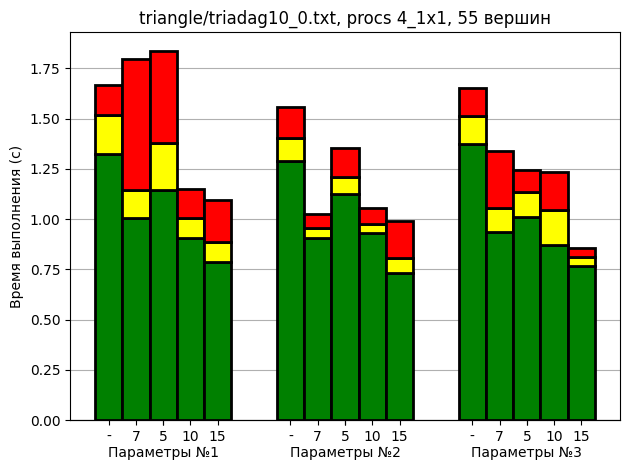

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


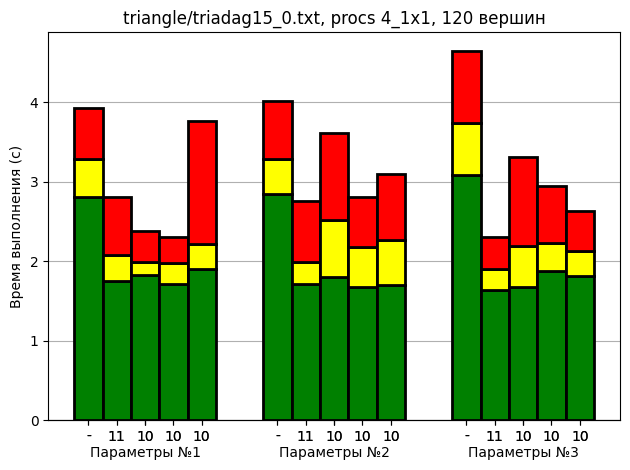

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


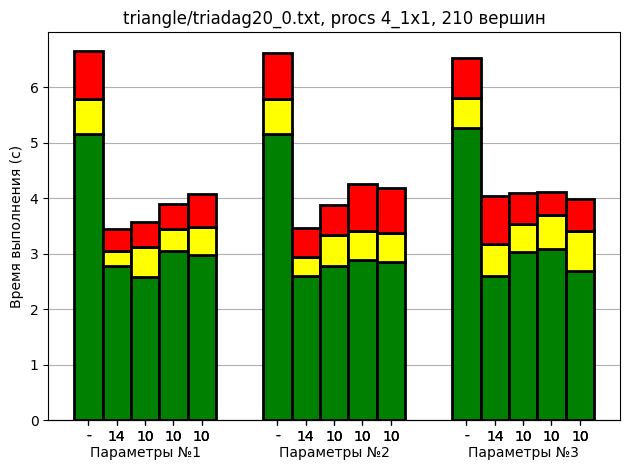

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


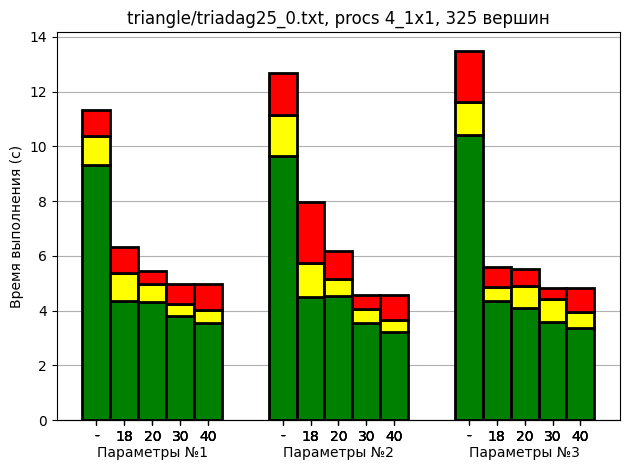

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


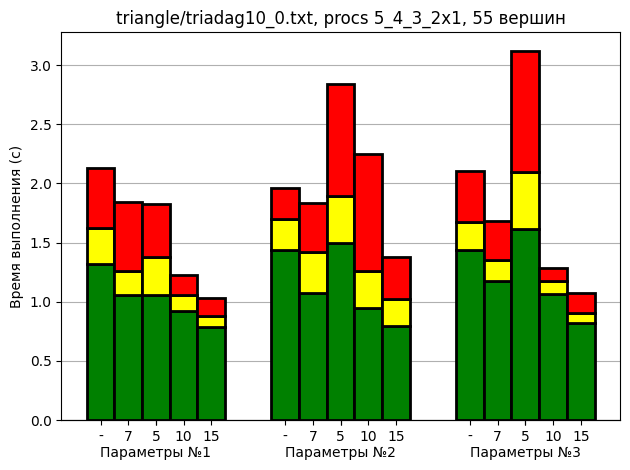

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


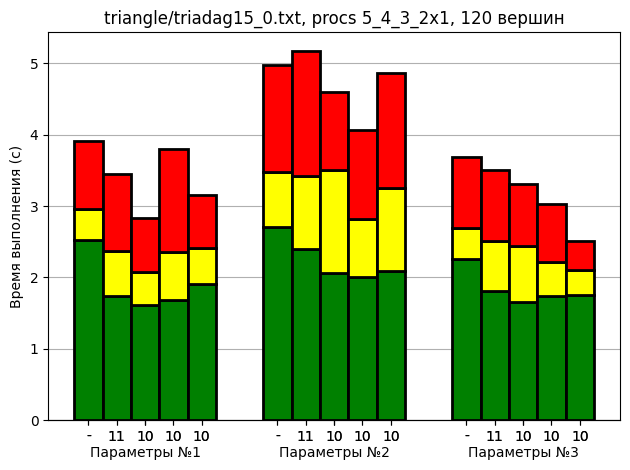

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


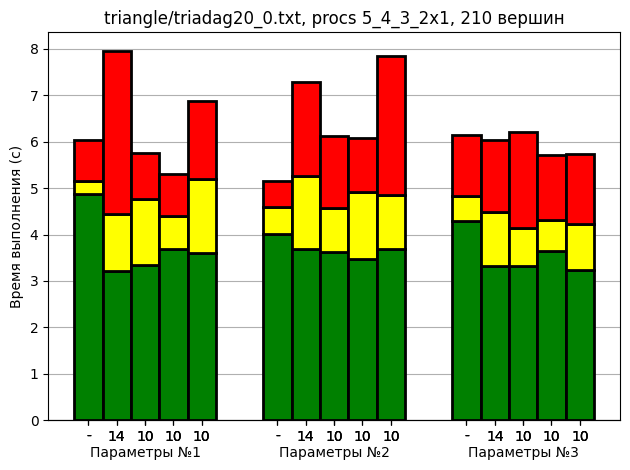

{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.05, "name": "mutShuffleIndexes"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}
{"mate": {"name": "cxTwoPoint"}, "mutate": {"indpb": 0.1, "name": "mutFlipBit"}, "ngen_without_1pct_improvement": 15, "population_size": 300, "select": {"name": "selTournament", "tournsize": 3}}


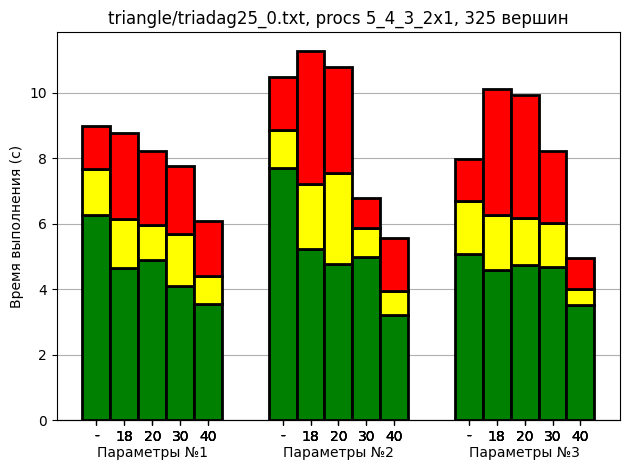

In [ ]:
width = 0.3
for graph_class in graph_classes:
    for pg_name in physical_graph_names_uniq:
        x = sorted(filter(lambda x: graph_class in x, list(graph_names_uniq)), key= lambda x: graph2size[x])
        x_ticks = []
        x_ticks_labels = []
        for graph_name in x:
            fig, ax = plt.subplots()
            x_pos = np.arange(0, 5, 2) 
            for j, ga_params in enumerate(sorted(list(ga_params_uniq))):
                # print(ga_params)
                ga_min = defaultdict(list)
                ga_max = defaultdict(list)
                ga_mean = defaultdict(list)
    
                for i, d_func in enumerate(sorted(list(d_functions_uniq))):
                    # print(graph_name, pg_name, ga_params, d_func)
                    mi = min(time_data[graph_name][pg_name][ga_params][d_func])
                    ma = max(time_data[graph_name][pg_name][ga_params][d_func])
                    me = np.mean(time_data[graph_name][pg_name][ga_params][d_func])

                    ax.bar([x_pos[j] + (i-2)*width], [mi], width, color = "green", edgecolor = "black", linewidth = 2)
                    ax1 = ax.bar([x_pos[j] + (i-2)*width], [me-mi], width, bottom=mi, color = "yellow", edgecolor = "black", linewidth = 2, label = "Yes")
                    ax.bar([x_pos[j] + (i-2)*width], [ma-me], width, bottom=me, color = "red", edgecolor = "black", linewidth = 2)
                    
                    if d_func != '':
                        x_ticks.append(x_pos[j] + (i-2)*width)
                        x_ticks_labels.append(d_functions_с[d_func](graph2size[graph_name]))
                    else:
                        x_ticks.append(x_pos[j] + (i-2)*width)
                        x_ticks_labels.append('-')
                    
                    # for r in ax1:
                    #     ax.text(r.get_x() + r.get_width() / 2,
                    #         # r.get_height() / 2 + r.get_y(),
                    #         r.get_height() / 2,
                    #         # -1,
                    #         # d_functions_с[d_func](graph2size[graph_name]), ha = 'center',
                    #         d_func, ha = 'center',
                    #         color = 'black', weight = 'bold', size = 10, rotation=90)


            plt.ylabel("Время выполнения (с)")
            # plt.xlabel("Набор параметров ГА")
            plt.xticks(x_ticks, x_ticks_labels)
            title = f'{graph_name}, procs {pg_name.strip(".txt")}, {(graph2size[graph_name])} вершин'
            ax.set_title(title)
            sec = ax.secondary_xaxis(location=0)
            sec.set_xticks(x_pos, labels=['\nПараметры №1', '\nПараметры №2', '\nПараметры №3'])
            fig.tight_layout()
            # plt.legend(["Round 1", "Round 2", "Round 3"])
            ax.grid(axis='y')
            ax.set_axisbelow(True)
            plt.show() 

In [ ]:
width = 0.3
for graph_class in graph_classes:
    for pg_name in physical_graph_names_uniq:
        x = sorted(filter(lambda x: graph_class in x, list(graph_names_uniq)), key= lambda x: graph2size[x])
        x_ticks = []
        x_ticks_labels = []
        for graph_name in x:
            fig, ax = plt.subplots()
            x_pos = np.arange(0, 5, 2) 
            for j, ga_params in enumerate(sorted(list(ga_params_uniq))):
                # print(ga_params)
                ga_min = defaultdict(list)
                ga_max = defaultdict(list)
                ga_mean = defaultdict(list)
    
                for i, d_func in enumerate(sorted(list(d_functions_uniq))):
                    # print(graph_name, pg_name, ga_params, d_func)
                    mi = min(f_data[graph_name][pg_name][ga_params][d_func])
                    ma = max(f_data[graph_name][pg_name][ga_params][d_func])
                    me = np.mean(f_data[graph_name][pg_name][ga_params][d_func])

                    ax.bar([x_pos[j] + (i-2)*width], [mi], width, color = "green", edgecolor = "black", linewidth = 2)
                    ax1 = ax.bar([x_pos[j] + (i-2)*width], [me-mi], width, bottom=mi, color = "yellow", edgecolor = "black", linewidth = 2, label = "Yes")
                    ax.bar([x_pos[j] + (i-2)*width], [ma-me], width, bottom=me, color = "red", edgecolor = "black", linewidth = 2)
                    
                    if d_func != '':
                        x_ticks.append(x_pos[j] + (i-2)*width)
                        x_ticks_labels.append(d_functions_с[d_func](graph2size[graph_name]))
                    else:
                        x_ticks.append(x_pos[j] + (i-2)*width)
                        x_ticks_labels.append('-')
                    
                    # for r in ax1:
                    #     ax.text(r.get_x() + r.get_width() / 2,
                    #         # r.get_height() / 2 + r.get_y(),
                    #         r.get_height() / 2,
                    #         # -1,
                    #         # d_functions_с[d_func](graph2size[graph_name]), ha = 'center',
                    #         d_func, ha = 'center',
                    #         color = 'black', weight = 'bold', size = 10, rotation=90)


            plt.ylabel("Целевая функция")
            # plt.xlabel("Набор параметров ГА")
            plt.xticks(x_ticks, x_ticks_labels)
            title = f'{graph_name}, procs {pg_name.strip(".txt")}, {(graph2size[graph_name])} вершин'
            ax.set_title(title)
            sec = ax.secondary_xaxis(location=0)
            sec.set_xticks(x_pos, labels=['\nПараметры №1', '\nПараметры №2', '\nПараметры №3'])
            fig.tight_layout()
            # plt.legend(["Round 1", "Round 2", "Round 3"])
            ax.grid(axis='y')
            ax.set_axisbelow(True)
            plt.show() 